In [2]:
%matplotlib inline
import matplotlib.pyplot as pl
import pystan
from pystan import StanModel

In [3]:
### Generate data from a Gaussian Process Simulator using PyStan:

# Simulator model:

# first model is a univariate model:

GP_simulator_model_1 = """

data {
  int<lower=1> N;
  real x[N];
}

transformed data {
  vector[N] mu;
  cov_matrix[N] Sigma;
  for (i in 1:N)
    mu[i] <- 0;
  for (i in 1:N)
    for (j in 1:N) {
      Sigma[i, j] <- exp(-pow(x[i] - x[j], 2)) + if_else(i==j, 0.1, 0.0);
      // The covariance matrix Sigma is not being computed efficiently here; 
      // see Section Section 15.3 of Stan Manual for a better approach.
    }      
}

parameters {
  vector[N] y;
}

model {
  y ~ multi_normal(mu, Sigma);
}

"""

# Compiled Stan Model
sm_sim_univariate = StanModel(model_code=GP_simulator_model_1)

In [4]:
# Second model is a multivariate model:

GP_simulator_model_2 = """

data {
  int<lower=1> D;
  int<lower=1> N;
  vector[D] x[N];
}

transformed data {
  vector[N] mu;
  cov_matrix[N] Sigma;
  for (i in 1:N)
    mu[i] <- 0;
  for (i in 1:N)
    for (j in 1:N) {
      Sigma[i, j] <- exp(-dot_self(x[i] - x[j])) + if_else(i==j, 0.1, 0.0);
      // The squared Euclidean distance calculation is done using the 
      // dot_self function, which returns the dot product of its argument 
      // with itself, here x[i] - x[j].
    }      
}

parameters {
  vector[N] y;
}

model {
  y ~ multi_normal(mu, Sigma);
}

"""

# Compiled Stan Model
sm_sim_multivariate = StanModel(model_code=GP_simulator_model_2)

In [5]:
# first model is a univariate model:

GP_simulator_model_3 = """

data {
  int<lower=1> N;
  real x[N];
}

transformed data {
  vector[N] mu;
  cov_matrix[N] Sigma;
  matrix[N, N] L;
  for (i in 1:N)
    mu[i] <- 0;
  for (i in 1:N)
    for (j in 1:N) {
      Sigma[i, j] <- exp(-pow(x[i] - x[j], 2)) + if_else(i==j, 0.1, 0.0);
      // The covariance matrix Sigma is not being computed efficiently here; 
      // see Section Section 15.3 of Stan Manual for a better approach.
    }  
    L <- cholesky_decompose(Sigma);
}

parameters {
  vector[N] z;
}

model {
  z ~ normal(0, 1);
}

generated quantities {
  vector[N] y;
  y <- mu + L * z;
}

"""

# Compiled Stan Model
sm_sim_univariate_with_Cholesky = StanModel(model_code=GP_simulator_model_3)

[ 0.1742669   2.37917108  3.13541832  3.18436593  3.37212595  4.5607533
  5.05343781  7.07813782  8.40544024  8.68349299]
[ 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2]
[ 0.4288224   0.30082883  0.28463081 -0.45413814 -0.07884266 -1.09857479
 -0.87774909  0.35753279  1.3058318   0.40464619]


<Container object of 3 artists>

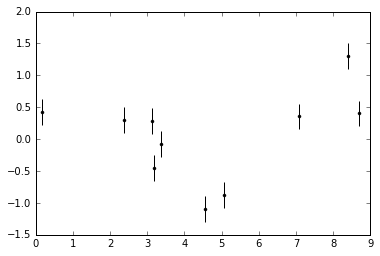

In [89]:
import numpy as np

# Generate some simple fake noisy data (later to compare to DFM Goerge tutorial).
N1 = 10
N2 = 100
x1 = N1 * np.sort(np.random.rand(N1))
yerr = 0.2 * np.ones_like(x1)
y1 = np.sin(x1) + yerr * np.random.randn(len(x1))
x2 = np.linspace(0, 10, N2)

data_p = {'N1':N1, 'N2':N2, 'x1':x1, 'x2':x2, 'y1':y1}

N = N1
x = x1
yerr = 0.2 * np.ones_like(x)
y = y1

print(x)
print(yerr)
print(y)

pl.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)



In [7]:
GP_test_model = """

data {
  int<lower=1> N;
  vector[N] x;
  vector[N] y;
  }

transformed data {
  vector[N] mu;
  for (i in 1:N) 
    mu[i] <- 0;
  }

parameters {
  real<lower=0> eta_sq;
  real<lower=0> inv_rho_sq;
  real<lower=0> sigma_sq;
}

transformed parameters {
  real<lower=0> rho_sq;
  rho_sq <- inv(inv_rho_sq);
} 

model {
  matrix[N, N] Sigma;
  // off-diagonal elements
  for (i in 1:(N-1)) {
    for (j in (i+1):N) {
      Sigma[i, j] <- eta_sq * exp(-rho_sq * pow(x[i] - x[j],2));
      Sigma[j, i] <- Sigma[i, j];
    } 
  }
      // diagonal elements
  for (k in 1:N)
    Sigma[k, k] <- eta_sq + sigma_sq;  // + jitter

// hyperpriors: 
// Because the hyperparameters are required to be positive and expected to 
// have reasonably small values, broad half-Cauchy distribu- tions act as 
// quite vague priors which could just as well be uniform over a constrained 
// range of values.

//  eta_sq ~ cauchy(0, );
//  inv_rho_sq ~ cauchy(0, 5);
//  sigma_sq ~ cauchy(0, 5);

  eta_sq ~ gamma(1,1); // increasing alpha and beta makes variance smaller, but depends.
  inv_rho_sq ~ uniform(0, 2);
  sigma_sq ~ gamma(1, 1);


  y ~ multi_normal(mu, Sigma);
}
  
"""

# Compiled Stan Model
sm = StanModel(model_code=GP_test_model)

In [91]:
data = {'N':N, 'x':x, 'y':y}

# Could set initial value to Max Likelihood solution without radius errors
#init = [{'lnf0':0.66,'alpha':-1.82,'beta':-0.65}]

fit = sm.sampling(data=data, iter=2000, chains=5, n_jobs=-1)

#get_inits(fit)

# Return a dictionary of arrays of posterior samples
la = fit.extract(permuted=True)  
#mu = la['mu']
#Sigma = la['Sigma']

eta_sq = la['eta_sq']
inv_rho_sq = la['inv_rho_sq']
sigma_sq = la['sigma_sq']
rho_sq = la['rho_sq']

a = fit.extract(permuted=False)
print(fit)



//anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
//anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
//anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
//anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
Wh

Inference for Stan model: anon_model_318d773aa8046d10b6661d1129ca999d.
5 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=5000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
eta_sq       0.46  5.4e-3   0.38   0.05   0.21   0.37    0.6   1.41 5000.0   1.01
inv_rho_sq   1.13  7.7e-3   0.54   0.12   0.69   1.18   1.61   1.96 5000.0    1.0
sigma_sq     0.33  3.7e-3   0.26   0.06   0.15   0.25   0.41   1.07 5000.0   1.02
rho_sq       1.75    0.06   4.52   0.51   0.62   0.85   1.45    8.2 5000.0    1.0
lp__        -4.22    0.02   1.44  -7.85  -4.94   -3.9  -3.16  -2.38 5000.0   1.01

Samples were drawn using NUTS(diag_e) at Mon Oct 24 13:43:45 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


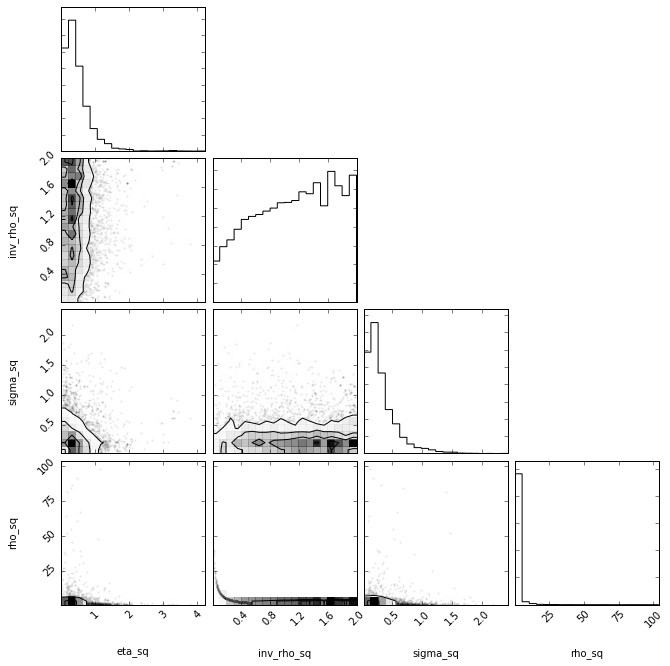

In [92]:
import corner

corner.corner(np.hstack((eta_sq.reshape(-1,1), inv_rho_sq.reshape(-1,1), sigma_sq.reshape(-1,1), rho_sq.reshape(-1,1))), labels=[r"eta_sq", r"inv_rho_sq", r"sigma_sq", r"rho_sq"]);


In [93]:
#print(sm)
print(eta_sq.shape)

(5000,)


In [95]:
### calculate the mean for the random variable y 
# tilda for each vector of hyper parameters using the formula 
# for this.  Then plot the mean and std for each x2 value (value you want to predict). 

In [96]:
print(fit)

Inference for Stan model: anon_model_318d773aa8046d10b6661d1129ca999d.
5 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=5000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
eta_sq       0.46  5.4e-3   0.38   0.05   0.21   0.37    0.6   1.41 5000.0   1.01
inv_rho_sq   1.13  7.7e-3   0.54   0.12   0.69   1.18   1.61   1.96 5000.0    1.0
sigma_sq     0.33  3.7e-3   0.26   0.06   0.15   0.25   0.41   1.07 5000.0   1.02
rho_sq       1.75    0.06   4.52   0.51   0.62   0.85   1.45    8.2 5000.0    1.0
lp__        -4.22    0.02   1.44  -7.85  -4.94   -3.9  -3.16  -2.38 5000.0   1.01

Samples were drawn using NUTS(diag_e) at Mon Oct 24 13:43:45 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


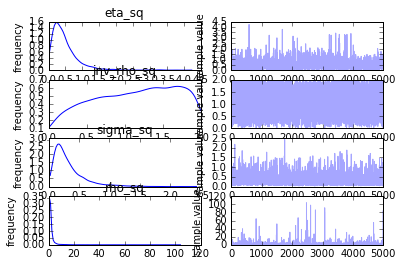

In [99]:
fig = fit.traceplot()

In [100]:
##  Build a prediction function
import pylab as py
import pandas as pd

In [18]:
# Predictive Inference with a Gaussian Process:

GP_test_predict_model_1 = """

data {
  int<lower=1> N1;
  int<lower=1> N2;
  vector[N1] x1;
  vector[N1] y1;
  vector[N2] x2;
}

transformed data {
  int<lower=1> N;
  vector[N1+N2] x;
  vector[N1+N2] mu;
  cov_matrix[N1+N2] Sigma;
  N <- N1 + N2;
  for (n in 1:N1) 
    x[n] <- x1[n]; 
  for (n in 1:N2) 
    x[N1 + n] <- x2[n];
  for (i in 1:N) 
    mu[i] <- 0;
  for (i in 1:N)
    for (j in 1:N) {
      Sigma[i, j] <- exp(-pow(x[i] - x[j],2)) + if_else(i==j, 0.1, 0.0);
    }
}
    
parameters {
  vector[N2] y2;
}

model {
  vector[N] y;
  for (n in 1:N1) y[n] <- y1[n];
  for (n in 1:N2) y[N1 + n] <- y2[n];
  y ~ multi_normal(mu, Sigma);
}

"""

# Compiled Stan Model
sm_p = StanModel(model_code=GP_test_predict_model_1)

In [19]:
## Cholesky Factorization Speedup of above model:

GP_test_predict_model_2 = """

data {
  int<lower=1> N1;
  int<lower=1> N2;
  vector[N1] x1;
  vector[N1] y1;
  vector[N2] x2;
}

transformed data {
  int<lower=1> N;
  vector[N1+N2] x;
  vector[N1+N2] mu;
  cov_matrix[N1+N2] Sigma;
  matrix[N1+N2, N1+N2] L;
  N <- N1 + N2;
  for (n in 1:N1) 
    x[n] <- x1[n]; 
  for (n in 1:N2) 
    x[N1 + n] <- x2[n];
  for (i in 1:N) 
    mu[i] <- 0;
  for (i in 1:N)
    for (j in 1:N) {
      Sigma[i, j] <- exp(-pow(x[i] - x[j],2)) + if_else(i==j, 0.1, 0.0);
    }
  L <- cholesky_decompose(Sigma);
}
    
parameters {
  vector[N2] y2;
}

model {
  vector[N] y;
  for (n in 1:N1) y[n] <- y1[n];
  for (n in 1:N2) y[N1 + n] <- y2[n];
  y ~ multi_normal_cholesky(mu,L);  
}

"""

# Compiled Stan Model
sm_p_Cholesky_speedup = StanModel(model_code=GP_test_predict_model_2)

In [101]:
# syntax for initialization dictionary, for 1 chain:
#init = [{'lnf0':0.66,'alpha':-1.82,'beta':-0.65}]

fit_p = sm_p_Cholesky_speedup.sampling(data=data_p, iter=1000, chains=5, n_jobs=-1)

# Return a dictionary of arrays of posterior samples
la_p = fit_p.extract(permuted=True)  

# Return numpy.ndarray' object:
a = fit_p.extract(permuted=False)

print(fit_p)

//anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
//anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
//anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
//anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
Wh

Inference for Stan model: anon_model_de9870d61844cb975dab0237eca9c73e.
5 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2500.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y2[0]    0.38  9.9e-3   0.49   -0.6   0.06   0.38   0.72   1.32 2500.0    1.0
y2[1]    0.39  9.0e-3   0.45  -0.51   0.07   0.38    0.7   1.26 2500.0    1.0
y2[2]    0.38  8.9e-3   0.44  -0.52   0.09   0.38   0.67   1.25 2500.0    1.0
y2[3]    0.37  9.2e-3   0.46  -0.55   0.07   0.37   0.68    1.3 2500.0    1.0
y2[4]    0.35    0.01   0.52   -0.7 6.4e-3   0.35    0.7   1.39 2500.0   1.01
y2[5]    0.32    0.01   0.59  -0.84  -0.09   0.32   0.73   1.46 2500.0   1.01
y2[6]    0.29    0.01   0.67  -1.04  -0.15   0.28   0.75   1.59 2500.0   1.01
y2[7]    0.25    0.01   0.75  -1.24  -0.24   0.25   0.73   1.72 2500.0   1.01
y2[8]    0.24    0.02   0.82  -1.38  -0.27   0.23   0.79   1.89 2500.0   1.01
y2[9]    0.21    0.02   0.88  -1.

(2500, 100)
(500, 5, 101)
(100,)


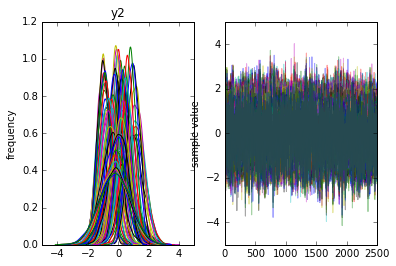

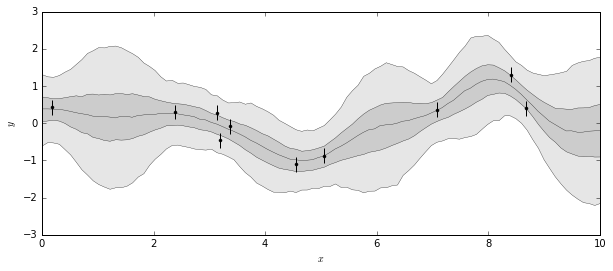

In [107]:
##### PREDICTION ####
 
# make a dataframe of parameter estimates for all chains
#params = pd.DataFrame({'eta_sq': fit.extract('eta_sq', permuted=True), 'sigma_sq': fit.extract('sigma_sq', permuted=True), 'rho_sq': fit.extract('rho_sq', permuted=True)})
      
# Dictionary
trace = fit_p.extract()
#print(trace.keys())
#print(trace['y2'][:].shape)
a = np.asarray(trace['y2'][:])
print(a.shape)
#print(a)


# numpy.ndarray' object:
# The first dimension of the array is for the iterations; the second for the number of 
# chains; the third for the parameters. Vectors and arrays are expanded to one parameter 
# (a scalar) per cell, with names indicating the third dimension. Parameters are listed 
# in the same order as model_pars and flatnames.
trace2 = fit_p.extract(permuted=False)
print(trace2.shape)
#print(trace2[4][4][49])


#print(fit_p)
fig = fit_p.traceplot()

#distance = [[[0 for k in xrange(n)] for j in xrange(n)] for i in xrange(n)]
np.percentile(a, 50, axis=0, interpolation='linear')
qt_50 = np.percentile(a, 50, axis=0, interpolation='linear')
qt_25 = np.percentile(a, 25, axis=0, interpolation='linear')
qt_75 = np.percentile(a, 75, axis=0, interpolation='linear')
qt_2_5 = np.percentile(a, 2.5, axis=0, interpolation='linear')
qt_97_5 = np.percentile(a, 97.5, axis=0, interpolation='linear')


print(qt_50.shape)
#print(qt_50)
#print(qt_25)
#print(qt_75)

ps_mu = np.mean(a, axis=0)
ps_std = np.std(a, axis=0)

pl.figure(figsize=(10,4))
#pl.subplot(1,2,1);
#pl.hist(trace['y2'][:][:], 25, histtype='step');
#pl.subplot(1,2,2);
pl.errorbar(x1, y1, yerr=yerr, fmt=".k", capsize=0)
#pl.plot(x2, ps_mu, "k", lw=0.3)
pl.plot(x2, qt_50, "k", lw=0.3)
#pl.fill_between(x2, ps_mu+std, ps_mu-std, color="0.9", alpha=1.0, edgecolor="k", lw=0.3)
pl.fill_between(x2, qt_2_5, qt_97_5, color="0.9", alpha=1.0, edgecolor="k", lw=0.3)
pl.fill_between(x2, qt_25, qt_75, color="0.8", alpha=1.0, edgecolor="k", lw=0.3)
pl.xlabel("$x$")
pl.ylabel("$y$")

#params = pd.DataFrame.from_records(fit_p)
#params = pd.DataFrame.from_records(fit_p, index=None, exclude=None, columns=None, coerce_float=False, nrows=None)




-11.8716069937
(100,)
(100,)
(100, 100)


(-1.5, 1.5)

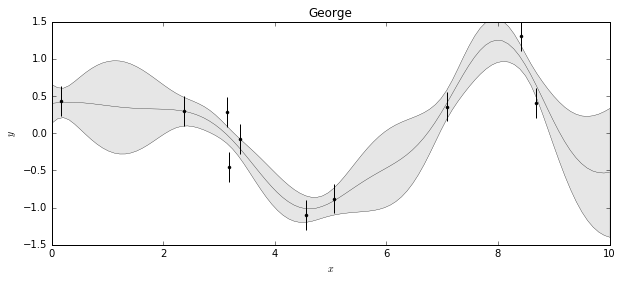

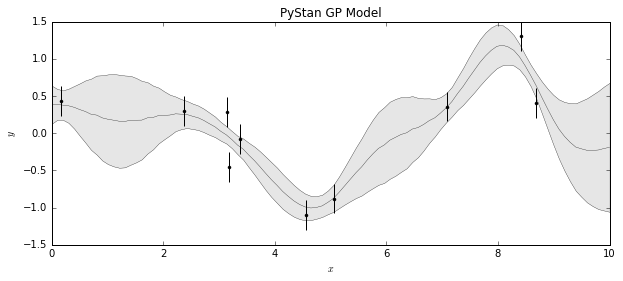

In [103]:
# Compare to DFM's George GP example:

import george
from george.kernels import ExpSquaredKernel

# Set up the Gaussian process.
kernel = ExpSquaredKernel(1.0)
gp = george.GP(kernel)

# Pre-compute the factorization of the matrix.
gp.compute(x1, yerr)

# Compute the log likelihood.
print(gp.lnlikelihood(y1))

mu, cov = gp.predict(y1, x2)
std = np.sqrt(np.diag(cov))
print(std.shape)
print(mu.shape)
print(cov.shape)

pl.figure(figsize=(10,4))
pl.errorbar(x1, y1, yerr=yerr, fmt=".k", capsize=0)
pl.plot(x2, mu, "k", lw=0.3)
#pl.fill_between(t, mu+std, mu-std, color="k", alpha=0.1, edgecolor="none")
pl.fill_between(x2, mu+std, mu-std, color="0.9", alpha=1.0, edgecolor="k", lw=0.3)
pl.xlabel("$x$")
pl.ylabel("$y$")
pl.title("George")
pl.xlim(0,10)
pl.ylim(-1.5,1.5)

pl.figure(figsize=(10,4))
#pl.subplot(1,2,1);
#pl.hist(trace['y2'][:][:], 25, histtype='step');
#pl.subplot(1,2,2);
pl.errorbar(x1, y1, yerr=yerr, fmt=".k", capsize=0)
pl.plot(x2, ps_mu, "k", lw=0.3)
#pl.plot(x2, qt_50, "k", lw=0.3)
pl.fill_between(x2, ps_mu+std, ps_mu-std, color="0.9", alpha=1.0, edgecolor="k", lw=0.3)
#pl.fill_between(x2, qt_25, qt_75, color="0.9", alpha=1.0, edgecolor="k", lw=0.3)
pl.xlabel("$x$")
pl.ylabel("$y$")
pl.title("PyStan GP Model")
pl.xlim(0,10)
pl.ylim(-1.5,1.5)




